In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.spatial.transform import Rotation
from sympy import Matrix, pi, pprint
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class TNG50DataProcessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.chunk_size = 102609 // 9
        self.load_data()

    def load_data(self):
        chunks = pd.read_csv(self.file_path, sep=' ', names=['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel', 'Potential', 'U', 'rho'], header=None, chunksize=self.chunk_size)
        self.accumulated_data = np.concatenate([chunk.values for chunk in chunks])

    def calculate_center_of_mass_new(self, value_energy=2.63):
        Log_energy = np.log10(self.accumulated_data[:, 10])
        avg_energy = np.mean(Log_energy)
        if value_energy == 1:
            value_energy = avg_energy
        energy_filter = Log_energy < value_energy
        self.filtered_data = self.accumulated_data[energy_filter]
        return np.sum(self.filtered_data[:, :3], axis=0) / len(self.accumulated_data)

    def calculate_total_angular_momentum(self):
        center_of_mass = self.calculate_center_of_mass_new()
        r_i = self.filtered_data[:, :3] - center_of_mass
        v_i = self.filtered_data[:, 3:6] - self.calculate_velocity_of_mass()
        return np.sum(np.cross(r_i, v_i), axis=0)

    def calculate_velocity_of_mass(self):
        return np.mean(self.filtered_data[:, 3:6], axis=0)

class RotationHandler:
    def __init__(self, direction):
      self.direction = direction
      direction = angular_direction[largest_component]
      pass

    def choose_rotation_matrix(self, largest_component, direction):
        if largest_component == 0:
            if direction == 1:
                matrix = Rotation.from_euler('y', -pi/2).as_matrix()
            elif direction == -1:
                matrix = Rotation.from_euler('y', pi/2).as_matrix()
        elif largest_component == 1:
            if direction == 1:
                matrix = Rotation.from_euler('x', pi/2).as_matrix()
            elif direction == -1:
                matrix = Rotation.from_euler('x', -pi/2).as_matrix()
        elif largest_component == 2:
            if direction == 1:
                matrix = np.identity(3)
            elif direction == -1:
                matrix = Rotation.from_euler('z', pi).as_matrix()
        return matrix

    def apply_rotation(self, matrix, vector):
        rotated_array = np.zeros_like(vector)
        if vector.size == 3:
            rotated_array = np.dot(matrix, vector)
        else:
            for i in range(vector.shape[0]):
                rotated_array[i, :] = np.dot(matrix, vector[i, :])
        return rotated_array

class VelocityEscapeCalculator:
    def __init__(self, data, potential):
        self.data = data
        self.potential = potential

    def calculate_magnitudes(self):
        velocity_magnitude = np.sqrt(np.sum(self.data[:, 3:6]**2, axis=1)).reshape(-1, 1)
        position_magnitude = np.sqrt(np.sum(self.data[:, :3]**2, axis=1)).reshape(-1, 1)
        self.data = np.concatenate([self.data, velocity_magnitude, position_magnitude], axis=1)

    def calculate_escape_velocity(self):
        escape_velocity = np.sqrt(2 * np.abs(self.potential)).reshape(-1, 1)
        self.data = np.concatenate([self.data, escape_velocity], axis=1)

    def get_processed_data(self):
        columns = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel', 'Potential', 'U', 'rho', 'velocity_magnitude', 'position_magnitude', 'escape_velocity']
        return pd.DataFrame(self.data, columns=columns)

class VisualizationHandler:
    def visualize_galaxy_one(self, rotated_vectors_filtered, center_of_mass, ax, title):
        ax.scatter(rotated_vectors_filtered[:, 0], rotated_vectors_filtered[:, 1], s=0.003, alpha=0.5)
        ax.scatter(center_of_mass[0], center_of_mass[1], color='red', s=0.3, marker='x')
        ax.set_title(title)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xlim(-18, 18)
        ax.set_ylim(-18, 18)
        ax.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
        ax.axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
        ax.grid(True, alpha=0.4)



## Description
We analyze data from various subhalos using the TNG50 dataset to calculate and visualize circular and escape velocities.


## Equations and approximations

Circular velocity is approximated as the magnitude of the velocity vector, v --- es independiente de la "orientaión" del dsico:

<p>
    <b>V<sub>circ</sub> ≈ |v| = √(v<sub>x</sub><sup>2</sup> + v<sub>y</sub><sup>2</sup> + v<sub>z</sub><sup>2</sup>)</b>
</p>
The escape velocity is calculated using the gravitational potential, Phi:

<p>
    <b>V<sub>esc</sub> = √(2 * |Φ|)</b>
</p>

Tarea: Escribir


Grid
8.848393206782838
7.339835208873933
8.160391997930674
16.89877671941203
14.975438385136998
15.05257696438933
15.867043718377753
22.773491238987518
23.123131297718817
23.97245067818144
30.52944004804588
30.49247720879044
30.607679895897803
31.806592769474584
30.58342016114375
28.873688700539024
40.9198939008762
38.53830350009545
38.57508573773385
38.51702481793223
38.67964877464978
39.037445105075044
40.761794026482455
46.19748878077732
46.34851591619883
46.535766752485245
46.789195313709634
47.48077140826706
47.20877195297742
47.6780270314977
46.32806004613767
45.700760920985566
45.26517891616778
53.840547332985984
54.20062176870576
54.547674548445684
54.78978084251009
55.99315566871096
56.64551281609128
54.02127661895186
52.31145266496997
56.79736805058793
52.297273239231174
60.41830298347711
62.28172954787877
62.42394936336719
62.49003958142896
62.93900835108592
61.225160890644624
63.0668885636974
65.48443234153653
71.65623478494149
70.09033619848698
70.3774931928424
70.54956230

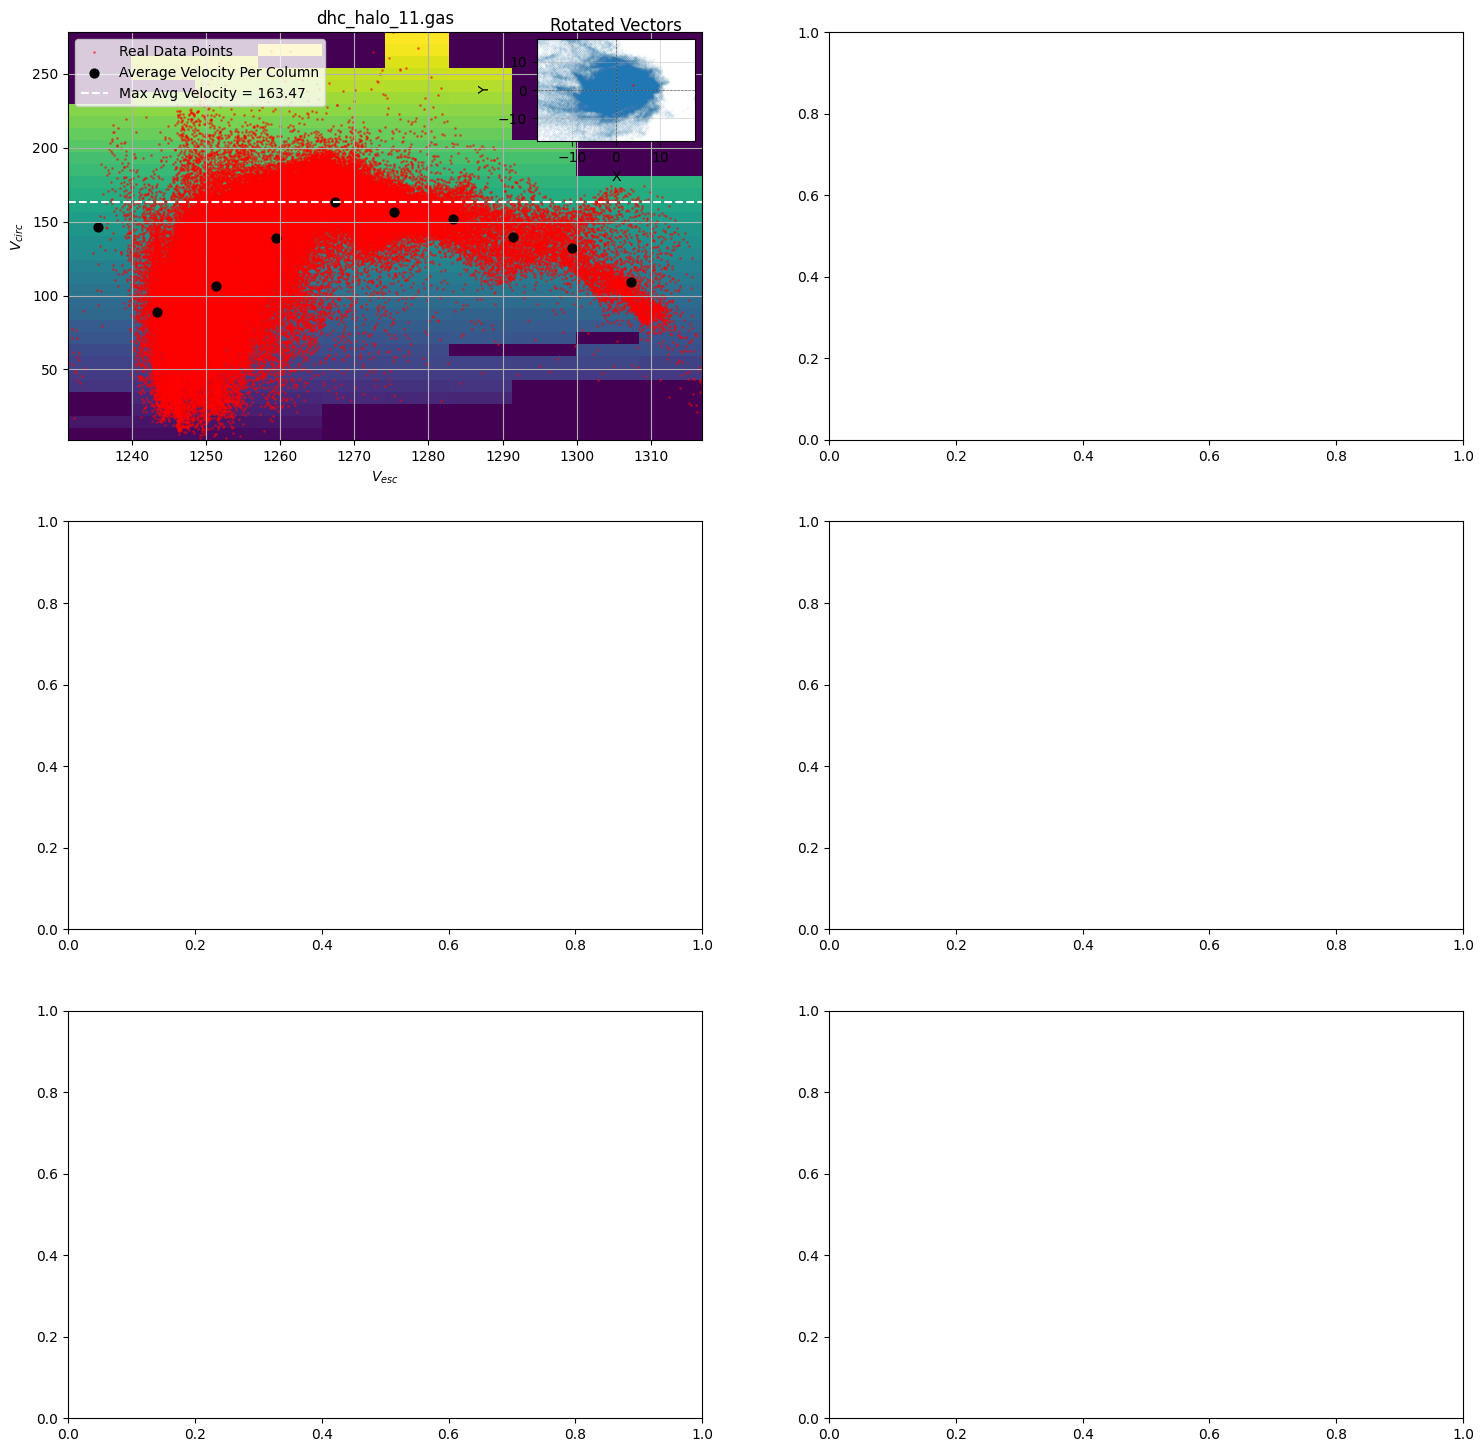

In [10]:
# Nombre de los archivos
halo_files = ['dhc_halo_11.gas']

fig, axs = plt.subplots(3, 2, figsize=(18, 18))
axs = axs.flatten()

for idx, file_path in enumerate(halo_files):
    simulation = TNG50DataProcessor(file_path)
    center_of_mass = simulation.calculate_center_of_mass_new(2.63)
    total_angular_momentum = simulation.calculate_total_angular_momentum()
    angular_direction = np.sign(total_angular_momentum)
    largest_component = np.argmax(np.abs(total_angular_momentum))
    direction = angular_direction[largest_component]

    rotation_handler = RotationHandler(direction)
    angle_rotation_matrix = rotation_handler.choose_rotation_matrix(largest_component, direction)

    original_vectors = simulation.accumulated_data[:, :3]
    velocity_vectors = simulation.accumulated_data[:, 3:6]
    rotated_vectors_position = rotation_handler.apply_rotation(angle_rotation_matrix, original_vectors)
    rotated_vectors_velocity = rotation_handler.apply_rotation(angle_rotation_matrix, velocity_vectors)

    rotated_data = np.concatenate([rotated_vectors_position, rotated_vectors_velocity, simulation.accumulated_data[:, 6:]], axis=1)
    potential = simulation.accumulated_data[:, 9]

    #Para los datos rotados se calculan magnitudes y cantidades
    calculator = VelocityEscapeCalculator(rotated_data, potential)
    calculator.calculate_magnitudes()
    calculator.calculate_escape_velocity()

    processed_data = calculator.get_processed_data()

    #Grid
    v_circ_min, v_circ_max = processed_data['velocity_magnitude'].min(), processed_data['velocity_magnitude'].max()
    v_esc_min, v_esc_max = processed_data['escape_velocity'].min(), processed_data['escape_velocity'].max()

    v_circ_bins = np.arange(v_circ_min, v_circ_max, 8)
    v_esc_bins = np.arange(v_esc_min, v_esc_max, 8)
    print('Grid')
    grid_data = np.zeros((len(v_circ_bins) - 1, len(v_esc_bins) - 1))
    point_density = np.zeros((len(v_circ_bins) - 1, len(v_esc_bins) - 1))

    for i, j in [(i, j) for i in range(len(v_circ_bins) - 1) for j in range(len(v_esc_bins) - 1)]:
        mask = ((processed_data['velocity_magnitude'] >= v_circ_bins[i]) &
                (processed_data['velocity_magnitude'] < v_circ_bins[i + 1]) &
                (processed_data['escape_velocity'] >= v_esc_bins[j]) &
                (processed_data['escape_velocity'] < v_esc_bins[j + 1]))

        points_in_cell = processed_data[mask]['velocity_magnitude']
        point_density[i, j] = len(points_in_cell)
        if len(points_in_cell) > 0:
            grid_data[i, j] = np.mean(points_in_cell)
            print( grid_data[i, j] )

    weighted_avg_velocity_per_column = [
        np.average(grid_data[:, j], weights=point_density[:, j]) if np.sum(point_density[:, j]) > 0 else np.nan
        for j in range(grid_data.shape[1])
    ]

    weighted_avg_velocity_per_column = np.array(weighted_avg_velocity_per_column)
    v_esc_midpoints = (v_esc_bins[:-1] + v_esc_bins[1:]) / 2
    max_avg_velocity = np.nanmax(weighted_avg_velocity_per_column)

    ax = axs[idx]
    ax.imshow(grid_data, origin='lower', aspect='auto', extent=[v_esc_min, v_esc_max, v_circ_min, v_circ_max], cmap='viridis')
    ax.scatter(processed_data['escape_velocity'], processed_data['velocity_magnitude'], color='red', s=1, alpha=0.45, label='Real Data Points')
    ax.scatter(v_esc_midpoints, weighted_avg_velocity_per_column, color='black', s=40, label='Average Velocity Per Column')
    ax.axhline(y=max_avg_velocity, color='white', linestyle='--', label=f'Max Avg Velocity = {max_avg_velocity:.2f}')
    ax.set_title(f'{file_path}')
    ax.set_xlabel(r'$V_{esc}$')
    ax.set_ylabel(r'$V_{circ}$')
    ax.legend(loc=2)
    ax.grid(True)

    ax_inset = inset_axes(ax, width="25%", height="25%", loc=1)
    visualization = VisualizationHandler()
    visualization.visualize_galaxy_one(rotated_vectors_position, center_of_mass, ax_inset, f'Rotated Vectors')

#plt.tight_layout()
plt.show();


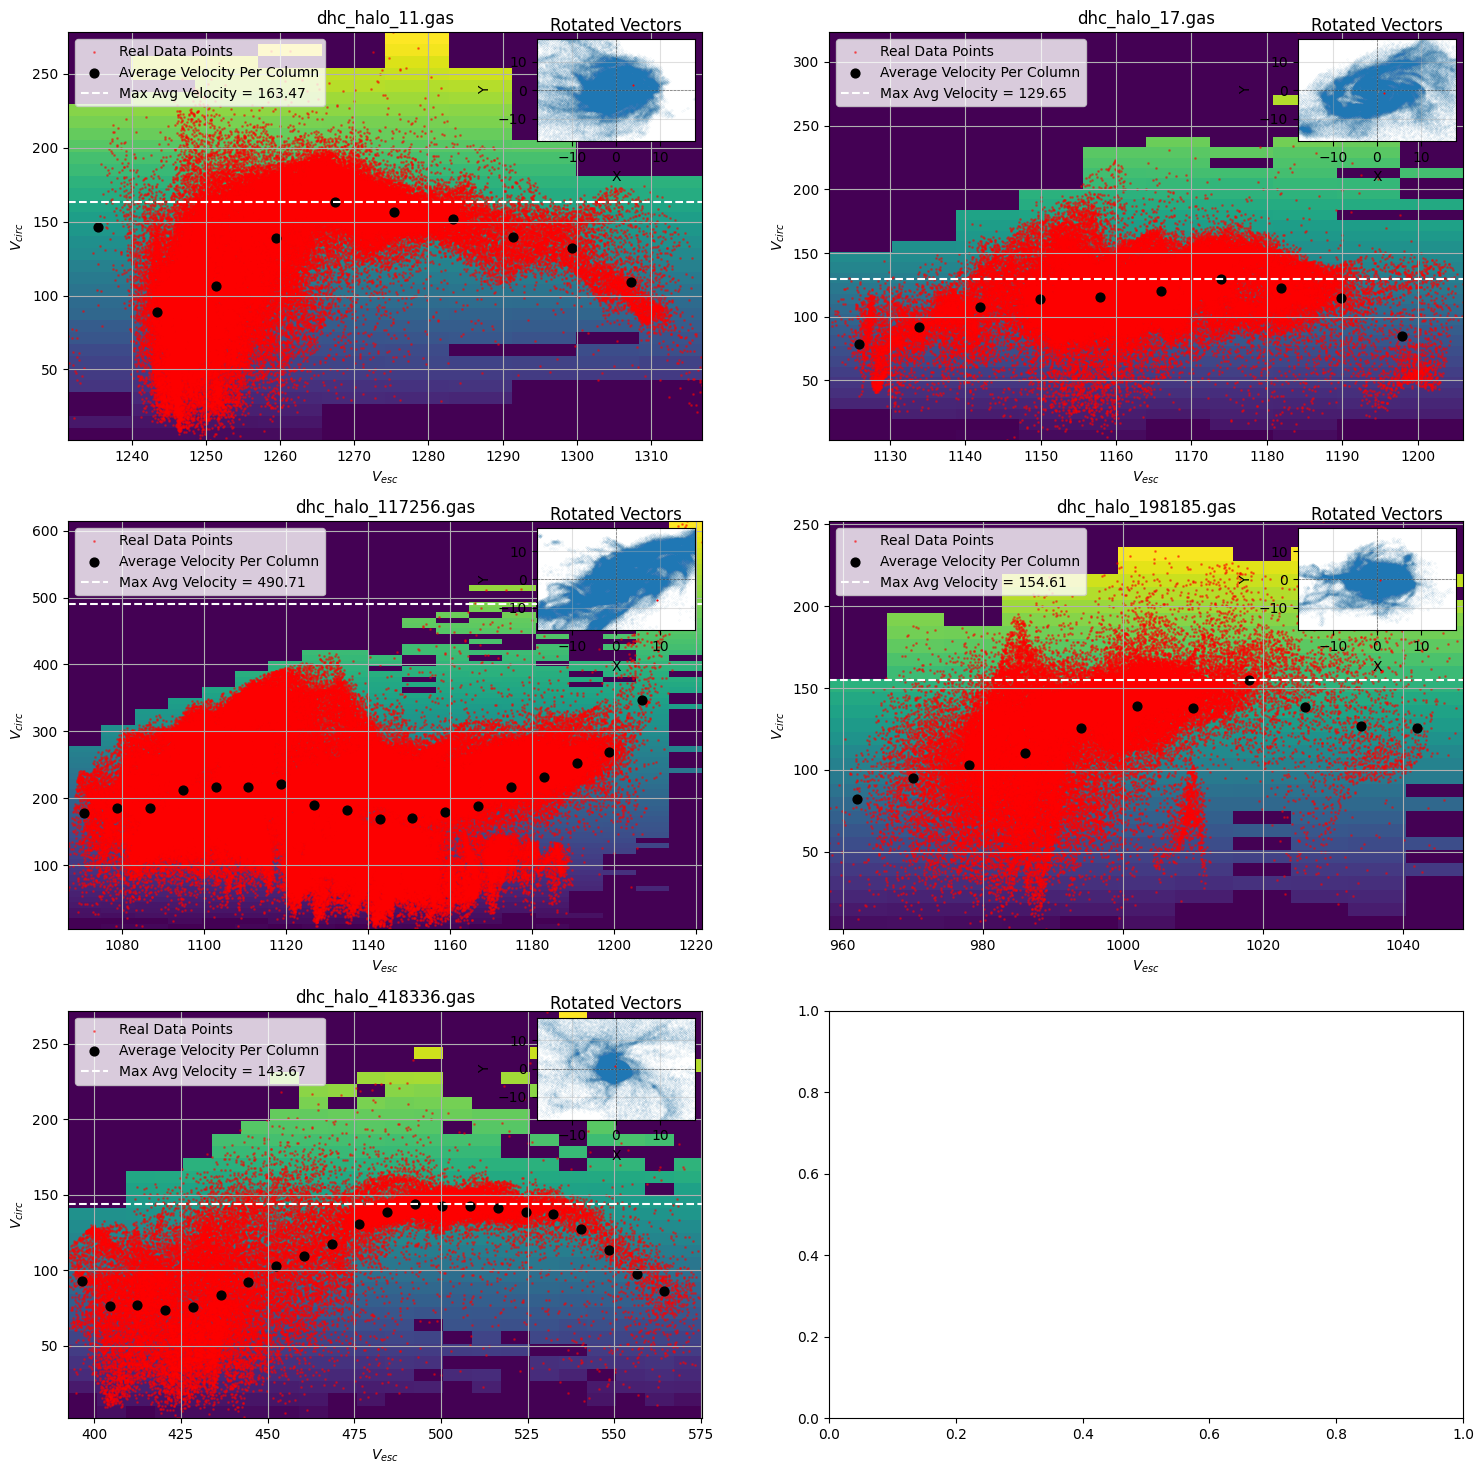

In [11]:
# Nombre de los archivos
halo_files = ['dhc_halo_11.gas', 'dhc_halo_17.gas', 'dhc_halo_117256.gas', 'dhc_halo_198185.gas', 'dhc_halo_418336.gas']

fig, axs = plt.subplots(3, 2, figsize=(18, 18))
axs = axs.flatten()

for idx, file_path in enumerate(halo_files):
    simulation = TNG50DataProcessor(file_path)
    center_of_mass = simulation.calculate_center_of_mass_new(2.63)
    total_angular_momentum = simulation.calculate_total_angular_momentum()
    angular_direction = np.sign(total_angular_momentum)
    largest_component = np.argmax(np.abs(total_angular_momentum))
    direction = angular_direction[largest_component]

    rotation_handler = RotationHandler(direction)
    angle_rotation_matrix = rotation_handler.choose_rotation_matrix(largest_component, direction)

    original_vectors = simulation.accumulated_data[:, :3]
    velocity_vectors = simulation.accumulated_data[:, 3:6]
    rotated_vectors_position = rotation_handler.apply_rotation(angle_rotation_matrix, original_vectors)
    rotated_vectors_velocity = rotation_handler.apply_rotation(angle_rotation_matrix, velocity_vectors)

    rotated_data = np.concatenate([rotated_vectors_position, rotated_vectors_velocity, simulation.accumulated_data[:, 6:]], axis=1)
    potential = simulation.accumulated_data[:, 9]

    #Para los datos rotados se calculan magnitudes y cantidades
    calculator = VelocityEscapeCalculator(rotated_data, potential)
    calculator.calculate_magnitudes()
    calculator.calculate_escape_velocity()

    processed_data = calculator.get_processed_data()

    #Grid
    v_circ_min, v_circ_max = processed_data['velocity_magnitude'].min(), processed_data['velocity_magnitude'].max()
    v_esc_min, v_esc_max = processed_data['escape_velocity'].min(), processed_data['escape_velocity'].max()

    v_circ_bins = np.arange(v_circ_min, v_circ_max, 8)
    v_esc_bins = np.arange(v_esc_min, v_esc_max, 8)

    grid_data = np.zeros((len(v_circ_bins) - 1, len(v_esc_bins) - 1))
    point_density = np.zeros((len(v_circ_bins) - 1, len(v_esc_bins) - 1))

    for i, j in [(i, j) for i in range(len(v_circ_bins) - 1) for j in range(len(v_esc_bins) - 1)]:
        mask = ((processed_data['velocity_magnitude'] >= v_circ_bins[i]) &
                (processed_data['velocity_magnitude'] < v_circ_bins[i + 1]) &
                (processed_data['escape_velocity'] >= v_esc_bins[j]) &
                (processed_data['escape_velocity'] < v_esc_bins[j + 1]))

        points_in_cell = processed_data[mask]['velocity_magnitude']
        point_density[i, j] = len(points_in_cell)
        if len(points_in_cell) > 0:
            grid_data[i, j] = np.mean(points_in_cell)

    weighted_avg_velocity_per_column = [
        np.average(grid_data[:, j], weights=point_density[:, j]) if np.sum(point_density[:, j]) > 0 else np.nan
        for j in range(grid_data.shape[1])
    ]

    weighted_avg_velocity_per_column = np.array(weighted_avg_velocity_per_column)
    v_esc_midpoints = (v_esc_bins[:-1] + v_esc_bins[1:]) / 2
    max_avg_velocity = np.nanmax(weighted_avg_velocity_per_column)

    ax = axs[idx]
    ax.imshow(grid_data, origin='lower', aspect='auto', extent=[v_esc_min, v_esc_max, v_circ_min, v_circ_max], cmap='viridis')
    ax.scatter(processed_data['escape_velocity'], processed_data['velocity_magnitude'], color='red', s=1, alpha=0.45, label='Real Data Points')
    ax.scatter(v_esc_midpoints, weighted_avg_velocity_per_column, color='black', s=40, label='Average Velocity Per Column')
    ax.axhline(y=max_avg_velocity, color='white', linestyle='--', label=f'Max Avg Velocity = {max_avg_velocity:.2f}')
    ax.set_title(f'{file_path}')
    ax.set_xlabel(r'$V_{esc}$')
    ax.set_ylabel(r'$V_{circ}$')
    ax.legend(loc=2)
    ax.grid(True)

    ax_inset = inset_axes(ax, width="25%", height="25%", loc=1)
    visualization = VisualizationHandler()
    visualization.visualize_galaxy_one(rotated_vectors_position, center_of_mass, ax_inset, f'Rotated Vectors')

#plt.tight_layout()
plt.show();


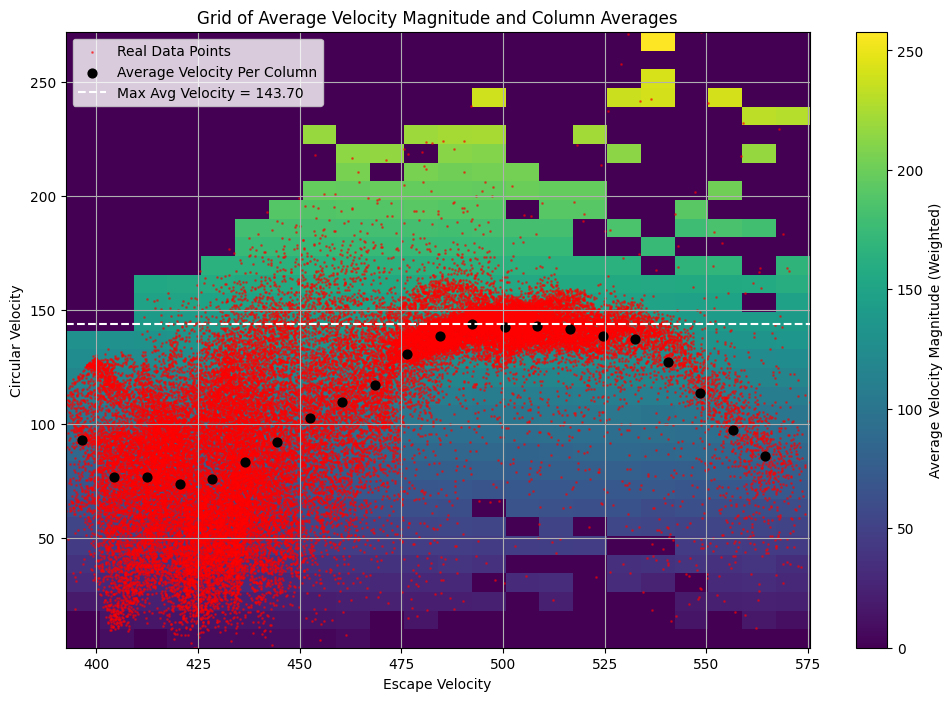

In [ ]:
plt.figure(figsize=(12, 8))

# Graficar el promedio ponderado en cada celda
plt.imshow(grid_data, origin='lower', aspect='auto', extent=[v_esc_min, v_esc_max, v_circ_min, v_circ_max], cmap='viridis')
plt.colorbar(label='Average Velocity Magnitude (Weighted)')
plt.scatter(processed_data['escape_velocity'], processed_data['velocity_magnitude'], color='red', s=1, alpha=0.5, label='Real Data Points')
plt.scatter(v_esc_midpoints, weighted_avg_velocity_per_column, color='black', s=40, label='Average Velocity Per Column')

# Graficar la línea horizontal del valor promedio máximo
plt.axhline(y=max_avg_velocity, color='white', linestyle='--', label=f'Max Avg Velocity = {max_avg_velocity:.2f}')

plt.title('Grid of Average Velocity Magnitude and Column Averages')
plt.xlabel('Escape Velocity')
plt.ylabel('Circular Velocity')
plt.legend()
plt.grid(True)
plt.show()

<h2>Detalle Matemático</h2>

<h3>1. Máscara de Filtrado</h3>
<p>Para cada celda <i>(i, j)</i>, definimos una máscara para seleccionar los datos:</p>

<p>$$ \text{mask} = (v_{\text{circ}} \in [v_{\text{circ\_bins}}[i], v_{\text{circ\_bins}}[i+1])) \ \cap \ (v_{\text{esc}} \in [v_{\text{esc\_bins}}[j], v_{\text{esc\_bins}}[j+1])) $$</p>

<pre><code>mask = (vcirc >= vcirc_bins[i]) & (vcirc < vcirc_bins[i+1]) & (vesc >= vesc_bins[j]) & (vesc < vesc_bins[j+1])</code></pre>

<h3>2. Puntos en la Celda</h3>
<p>Seleccionamos los puntos que caen dentro de la celda <i>(i, j)</i> usando la máscara:</p>

<p>$$ \text{points_in_cell} = \{ v_{\text{circ}} \mid \text{mask} \} $$</p>

<pre><code>points_in_cell = vcirc[mask]</code></pre>

<h3>3. Densidad de Puntos en cada Celda</h3>
<p>La densidad de puntos en la celda <i>(i, j)</i> se calcula como el número total de puntos en la celda:</p>

<p>$$ \text{density}[i, j] = N = \left| \text{points_in_cell} \right| $$</p>

<pre><code>density[i, j] = len(points_in_cell)</code></pre>

<h3>4. Promedio en la Celda</h3>
<p>Si la celda contiene puntos, calculamos el promedio de la velocidad circular en la celda <i>(i, j)</i>:</p>

<p>$$ \text{mean_vcirc}[i, j] = \frac{1}{N} \sum_{k \in \text{points_in_cell}} v_{\text{circ}, k} $$</p>

<pre><code>if density[i, j] > 0:
    mean_vcirc[i, j] = np.mean(points_in_cell)
else:
    mean_vcirc[i, j] = np.nan</code></pre>

<h3>5. Cálculo del Promedio Ponderado por Columna</h3>
<p>Para cada columna <i>j</i> del grid, calculamos el promedio ponderado de la velocidad circular. Esto implica ponderar cada celda por su densidad de puntos:</p>

<p>$$ \text{weighted_avg_vcirc}[j] = \frac{\sum_{i} (\text{density}[i, j] \cdot \text{mean_vcirc}[i, j])}{\sum_{i} \text{density}[i, j]} $$</p>

<p>Este valor se calcula solo si \(\sum_{i} \text{density}[i, j] > 0\), de lo contrario, el valor es \(\text{NaN}\).</p>

$$ \text{weighted_avg_velocity_per_column}[j] = \frac{\sum_{i} ( \text{N} \cdot \frac{\sum_{k}  v_{\text{circ}, k}}{N } ) }{\sum_{i} \text{N} }$$

$$ \text{weighted_avg_velocity_per_column}[j] = \frac{\sum_{i} {( \sum_{k}  v_{\text{circ}, k}} ) }{\sum_{i} \text{N} }$$





<ipython-input-21-ca1493b529b9>:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


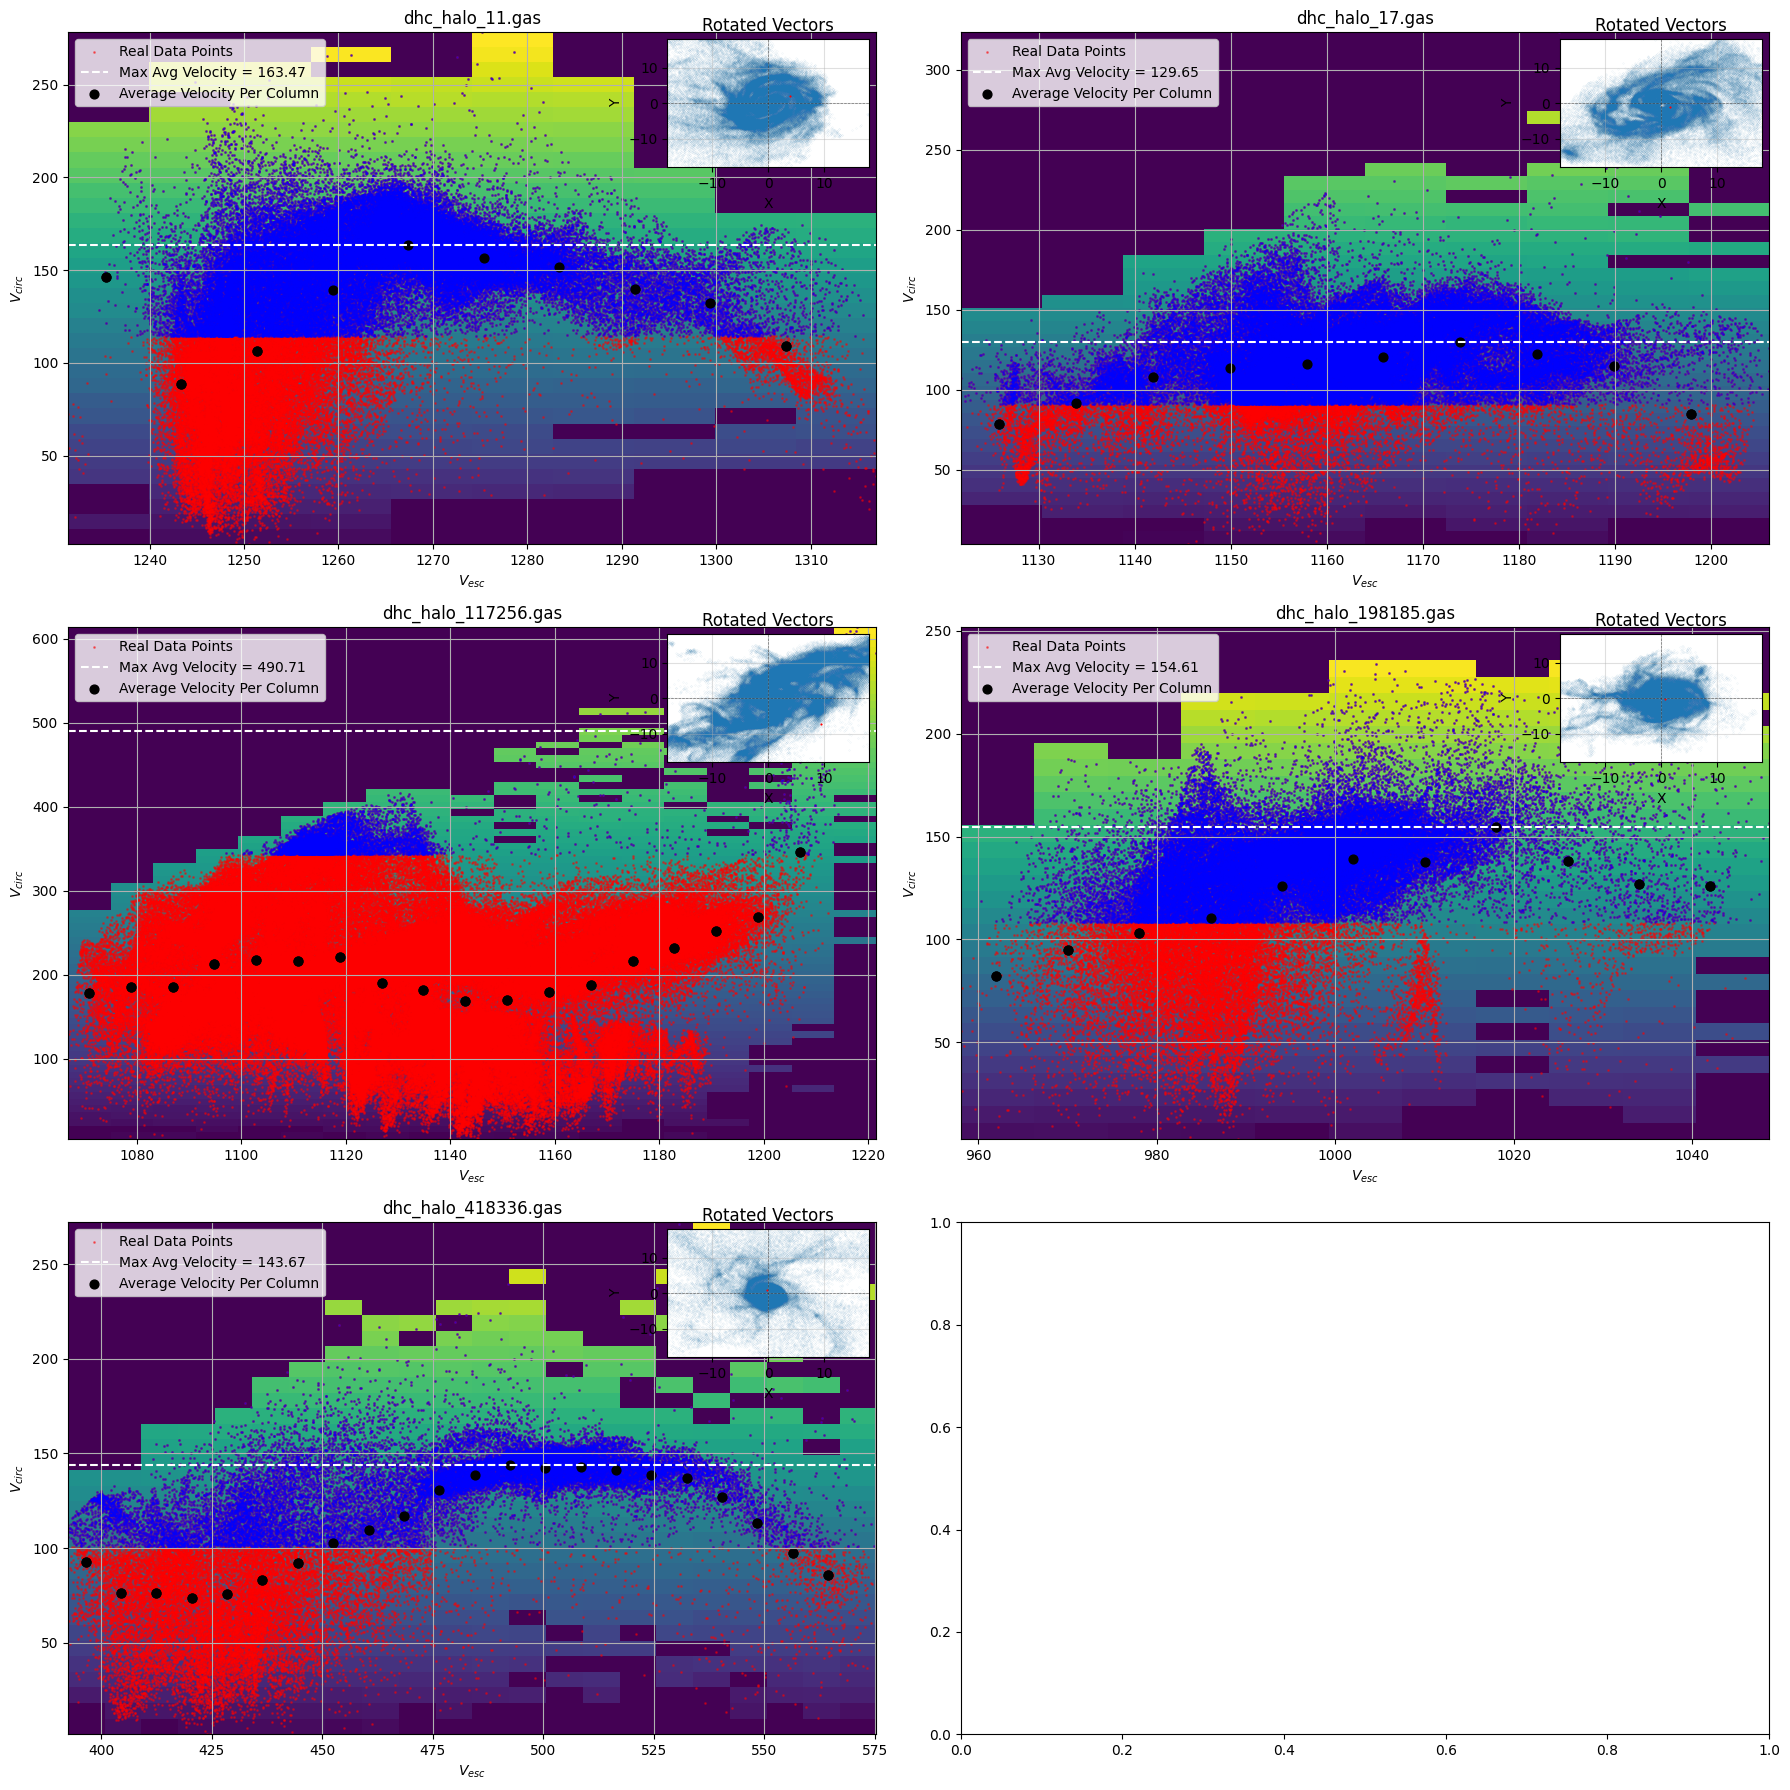

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Asumiendo que ya tienes las clases TNG50DataProcessor, RotationHandler, VelocityEscapeCalculator y VisualizationHandler

# Nombre de los archivos
halo_files = ['dhc_halo_11.gas', 'dhc_halo_17.gas', 'dhc_halo_117256.gas', 'dhc_halo_198185.gas', 'dhc_halo_418336.gas']

fig, axs = plt.subplots(3, 2, figsize=(18, 18))
axs = axs.flatten()

for idx, file_path in enumerate(halo_files):
    simulation = TNG50DataProcessor(file_path)
    center_of_mass = simulation.calculate_center_of_mass_new(2.63)
    total_angular_momentum = simulation.calculate_total_angular_momentum()
    angular_direction = np.sign(total_angular_momentum)
    largest_component = np.argmax(np.abs(total_angular_momentum))
    direction = angular_direction[largest_component]

    rotation_handler = RotationHandler(direction)
    angle_rotation_matrix = rotation_handler.choose_rotation_matrix(largest_component, direction)

    original_vectors = simulation.accumulated_data[:, :3]
    velocity_vectors = simulation.accumulated_data[:, 3:6]
    rotated_vectors_position = rotation_handler.apply_rotation(angle_rotation_matrix, original_vectors)
    rotated_vectors_velocity = rotation_handler.apply_rotation(angle_rotation_matrix, velocity_vectors)

    rotated_data = np.concatenate([rotated_vectors_position, rotated_vectors_velocity, simulation.accumulated_data[:, 6:]], axis=1)
    potential = simulation.accumulated_data[:, 9]

    #Para los datos rotados se calculan magnitudes y cantidades
    calculator = VelocityEscapeCalculator(rotated_data, potential)
    calculator.calculate_magnitudes()
    calculator.calculate_escape_velocity()

    processed_data = calculator.get_processed_data()

    #Grid
    v_circ_min, v_circ_max = processed_data['velocity_magnitude'].min(), processed_data['velocity_magnitude'].max()
    v_esc_min, v_esc_max = processed_data['escape_velocity'].min(), processed_data['escape_velocity'].max()

    v_circ_bins = np.arange(v_circ_min, v_circ_max, 8)
    v_esc_bins = np.arange(v_esc_min, v_esc_max, 8)

    grid_data = np.zeros((len(v_circ_bins) - 1, len(v_esc_bins) - 1))
    point_density = np.zeros((len(v_circ_bins) - 1, len(v_esc_bins) - 1))

    for i, j in [(i, j) for i in range(len(v_circ_bins) - 1) for j in range(len(v_esc_bins) - 1)]:
        mask = ((processed_data['velocity_magnitude'] >= v_circ_bins[i]) &
                (processed_data['velocity_magnitude'] < v_circ_bins[i + 1]) &
                (processed_data['escape_velocity'] >= v_esc_bins[j]) &
                (processed_data['escape_velocity'] < v_esc_bins[j + 1]))

        points_in_cell = processed_data[mask]['velocity_magnitude']
        point_density[i, j] = len(points_in_cell)
        if len(points_in_cell) > 0:
            grid_data[i, j] = np.mean(points_in_cell)

    weighted_avg_velocity_per_column = [
        np.average(grid_data[:, j], weights=point_density[:, j]) if np.sum(point_density[:, j]) > 0 else np.nan
        for j in range(grid_data.shape[1])
    ]

    weighted_avg_velocity_per_column = np.array(weighted_avg_velocity_per_column)
    v_esc_midpoints = (v_esc_bins[:-1] + v_esc_bins[1:]) / 2
    max_avg_velocity = np.nanmax(weighted_avg_velocity_per_column)

    # Filtrar las partículas que cumplen con el criterio del 70% de la velocidad máxima promedio
    threshold = 0.7 * max_avg_velocity
    filtered_data = processed_data[processed_data['velocity_magnitude'] > threshold]

    ax = axs[idx]
    ax.imshow(grid_data, origin='lower', aspect='auto', extent=[v_esc_min, v_esc_max, v_circ_min, v_circ_max], cmap='viridis')
    ax.scatter(processed_data['escape_velocity'], processed_data['velocity_magnitude'], color='red', s=1, alpha=0.45, label='Real Data Points')
    ax.axhline(y=max_avg_velocity, color='white', linestyle='--', label=f'Max Avg Velocity = {max_avg_velocity:.2f}')
    ax.scatter(v_esc_midpoints, weighted_avg_velocity_per_column, color='black', s=40, label='Average Velocity Per Column')

    ax.set_title(f'{file_path}')
    ax.set_xlabel(r'$V_{esc}$')
    ax.set_ylabel(r'$V_{circ}$')
    ax.legend(loc=2)
    ax.grid(True)

    # Agregar datos filtrados
    ax.scatter(filtered_data['escape_velocity'], filtered_data['velocity_magnitude'], color='blue', s=1, alpha=0.45, label='Filtered Data')
    ax.scatter(v_esc_midpoints, weighted_avg_velocity_per_column, color='black', s=40, label='Average Velocity Per Column')

    ax_inset = inset_axes(ax, width="25%", height="25%", loc=1)
    visualization = VisualizationHandler()
    visualization.visualize_galaxy_one(rotated_vectors_position, center_of_mass, ax_inset, f'Rotated Vectors')

plt.tight_layout()
plt.show();


x          y          z         vx         vy         vz  \
0       0.167932  -0.227129  -0.086740  22.270559 -11.409050 -27.206598   
1       0.170316  -0.231437  -0.071959  22.920490   3.481564 -29.786688   
2       0.102061   0.136488  -0.156234 -55.398716  20.946133 -11.696455   
3       0.223363  -0.064558  -0.209253 -19.203720   8.906288 -40.995853   
4      -0.070473  -0.282936  -0.034195  25.131836 -57.911583 -25.954632   
...          ...        ...        ...        ...        ...        ...   
43876  -3.690915   2.435539  17.240426 -19.818369  65.687057  47.616413   
43889  -7.310537  10.199918  -7.200729  -3.505687  53.147976 -22.811237   
43896  17.465048  16.940642  -7.262417  25.202276  48.685589   3.335838   
43903  -7.470412  -4.536630  24.478330 -64.784630  71.024559  -3.632021   
43905  18.713182  12.980490  -5.126571 -10.131723  80.029083 -41.823082   

           lxvel      lyvel      lzvel      Potential             U       rho  \
0     -25.661901  -0.797493 -23.389589 -164270.406250    702.626404  0.006426   
1     -28.241991  14.093121 -24.039520 -163815.156250    797.898499  0.008194   
2     -10.151758  31.557690  54.279686 -164842.296875   1117.395996  0.016473   
3     -39.451157  19.517845  18.084690 -163345.421875    705.183350  0.005222   
4     -24.409935 -47.300026 -26.250866 -164547.218750    746.246094  0.005517   
...          ...        ...        ...            ...           ...       ...   
43876  49.161110  76.298615  18.699339  -89814.007812  11491.198242  0.000001   
43889 -21.266541  63.759533   2.386657  -92203.593750  16313.725586  0.000002   
43896   4.880535  59.297146 -26.321306  -83548.250000   9448.736328  0.000001   
43903  -2.087324  81.636116  63.665600  -86300.304688   6112.842773  0.000001   
43905 -40.278385  90.640640   9.012693  -84914.164062   7495.190430  0.000002   

       velocity_magnitude  position_magnitude  escape_velocity  
0               36.964080            0.295487       573.184798  
1               37.745423            0.296224       572.390000  
2               60.370235            0.231202       574.181673  
3               46.138539            0.312803       571.568757  
4               68.256894            0.293579       573.667532  
...                   ...                 ...              ...  
43876           83.515747           17.798511       423.825454  
43889           57.942642           14.468337       429.426580  
43896           54.923302           25.392045       408.774388  
43903           96.201496           25.991858       415.452295  
43905           90.865154           23.344336       412.102327  

[19166 rows x 15 columns]

In [15]:
def visualize_filtered_data(filtered_positions, center_of_mass, title):
    # Crear una figura con un subgráfico
    fig, ax = plt.subplots(figsize=(10, 10))

    # Gráfico de las posiciones filtradas
    ax.scatter(filtered_positions[:, 0], filtered_positions[:, 1], color='blue', marker='o', s=0.003, label='Filtered Positions')
    ax.scatter(center_of_mass[0], center_of_mass[1], color='red', marker='x', s=5, label='Center of Mass')
    ax.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)

    ax.set_title(title)
    ax.set_xlim(-18, 18)
    ax.set_ylim(-18, 18)
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.legend()

    # Ajustar el diseño para evitar superposiciones
    plt.tight_layout()
    plt.show()

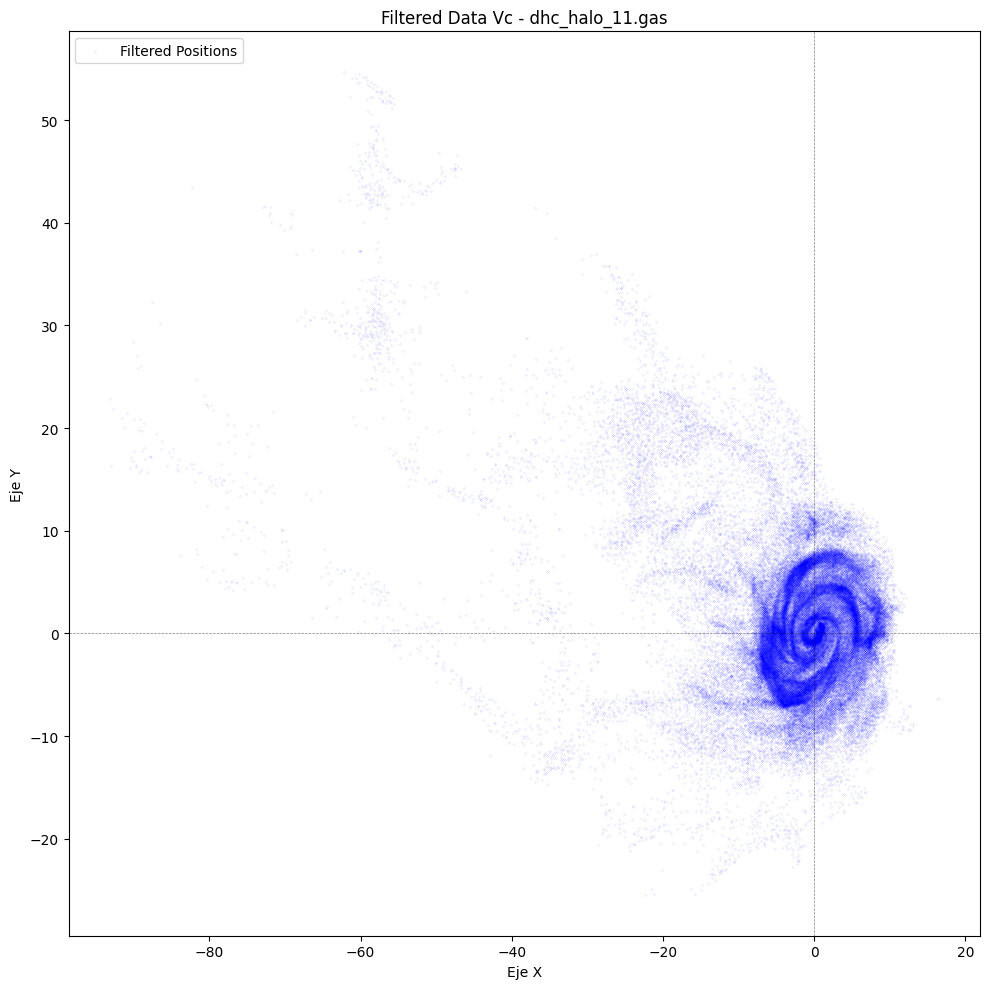

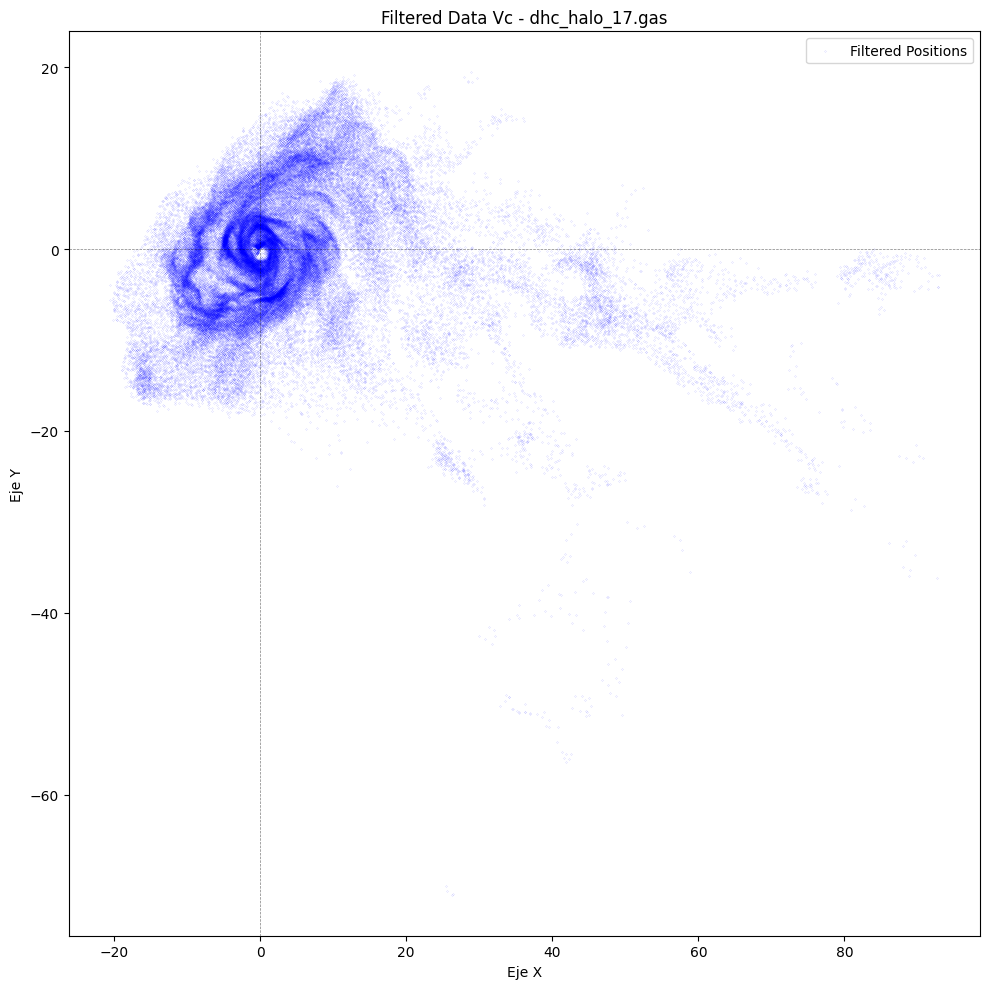

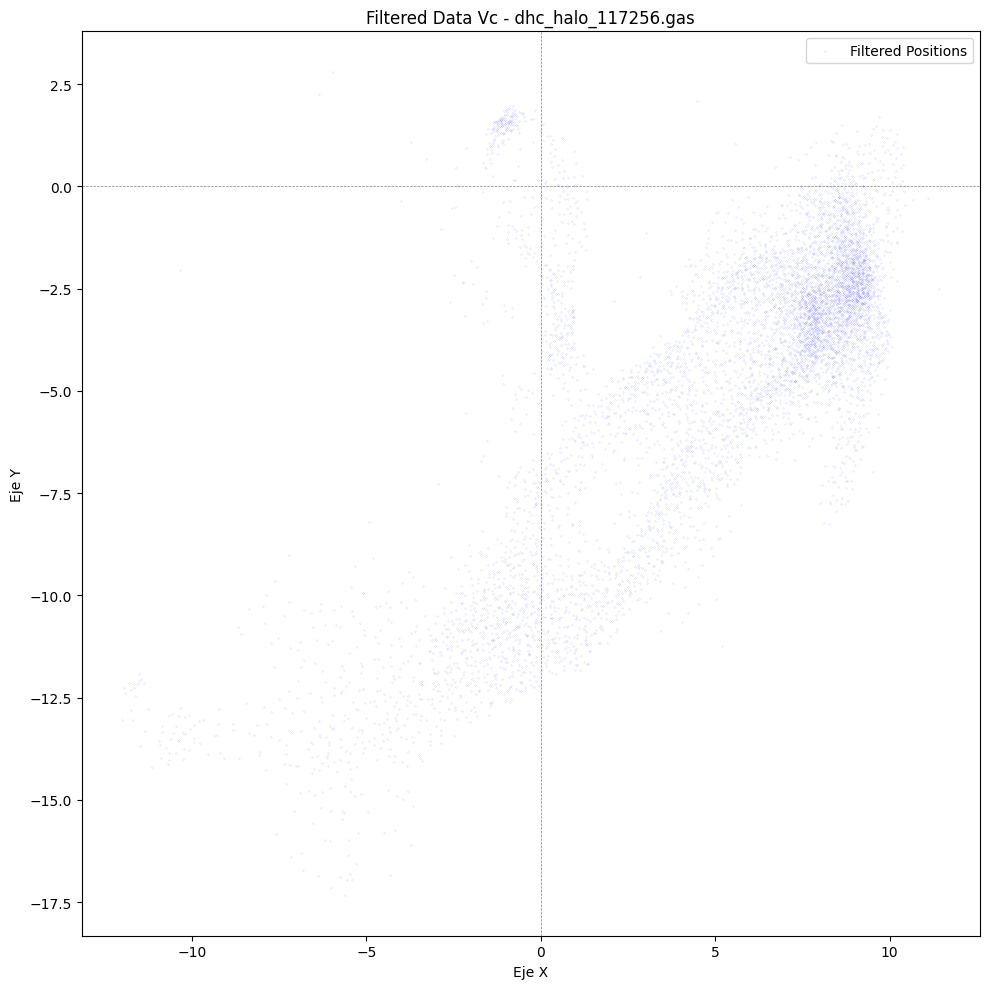

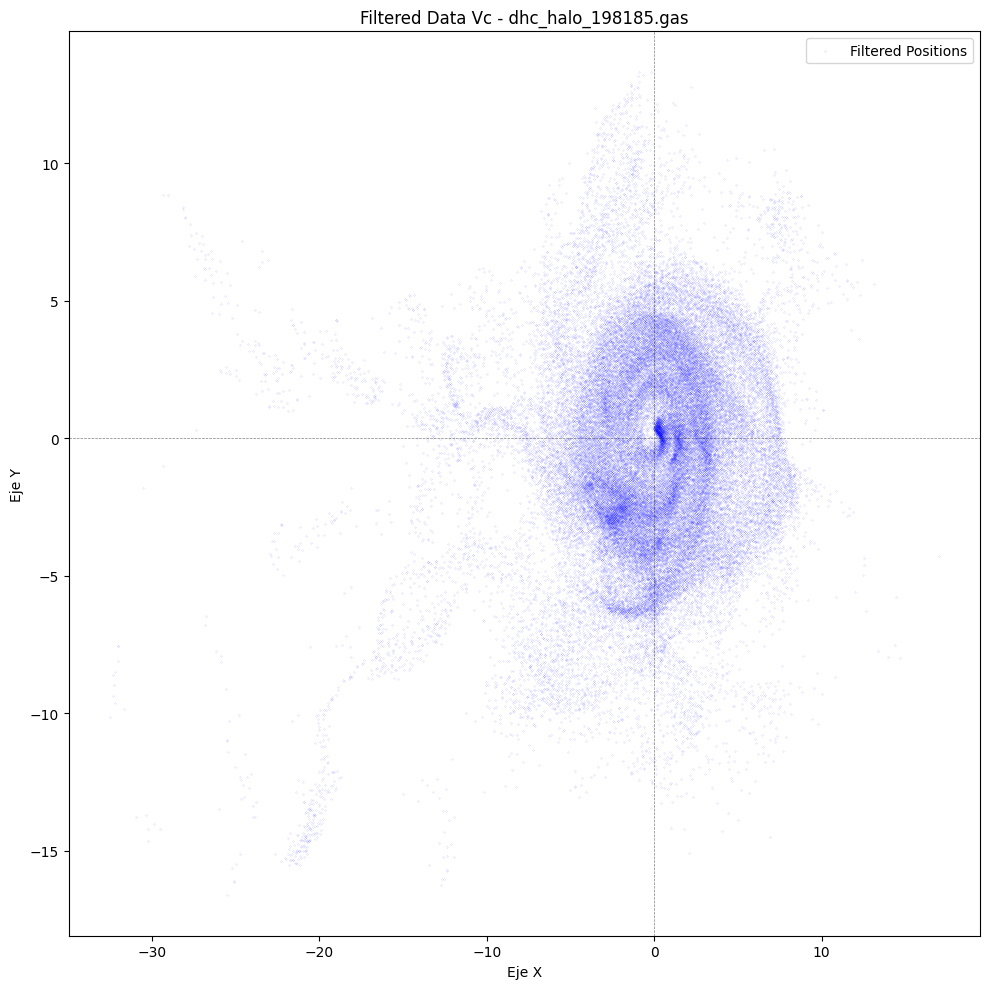

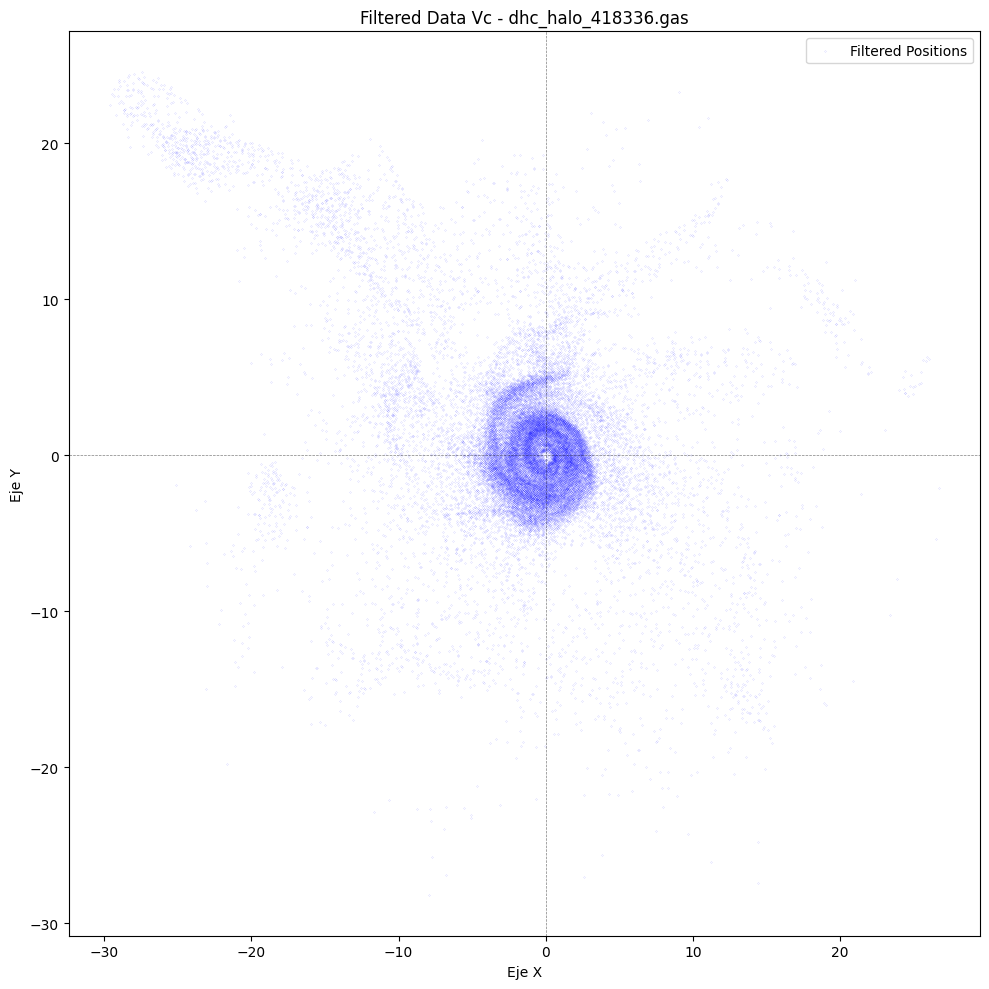

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

def visualize_filtered_data(filtered_df, title):
    # Crear una figura con un subgráfico
    fig, ax = plt.subplots(figsize=(10, 10))

    # Gráfico de las posiciones filtradas
    ax.scatter(filtered_df.iloc[:, 0], filtered_df.iloc[:, 1], color='blue', marker='o', s=0.003, label='Filtered Positions')
    ax.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)

    ax.set_title(title)
    #ax.set_xlim(-18, 18)
    #ax.set_ylim(-18, 18)
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.legend()

    # Ajustar el diseño para evitar superposiciones
    plt.tight_layout()
    plt.show()

# Nombre de los archivos
halo_files = ['dhc_halo_11.gas', 'dhc_halo_17.gas', 'dhc_halo_117256.gas', 'dhc_halo_198185.gas', 'dhc_halo_418336.gas']

filtered_dataframes = {}

for idx, file_path in enumerate(halo_files):
    simulation = TNG50DataProcessor(file_path)
    center_of_mass = simulation.calculate_center_of_mass_new(2.63)
    total_angular_momentum = simulation.calculate_total_angular_momentum()
    angular_direction = np.sign(total_angular_momentum)
    largest_component = np.argmax(np.abs(total_angular_momentum))
    direction = angular_direction[largest_component]

    rotation_handler = RotationHandler(direction)
    angle_rotation_matrix = rotation_handler.choose_rotation_matrix(largest_component, direction)

    original_vectors = simulation.accumulated_data[:, :3]
    velocity_vectors = simulation.accumulated_data[:, 3:6]
    rotated_vectors_position = rotation_handler.apply_rotation(angle_rotation_matrix, original_vectors)
    rotated_vectors_velocity = rotation_handler.apply_rotation(angle_rotation_matrix, velocity_vectors)

    rotated_data = np.concatenate([rotated_vectors_position, rotated_vectors_velocity, simulation.accumulated_data[:, 6:]], axis=1)
    potential = simulation.accumulated_data[:, 9]

    # Para los datos rotados se calculan magnitudes y cantidades
    calculator = VelocityEscapeCalculator(rotated_data, potential)
    calculator.calculate_magnitudes()
    calculator.calculate_escape_velocity()

    processed_data = calculator.get_processed_data()

    # Grid
    v_circ_min, v_circ_max = processed_data['velocity_magnitude'].min(), processed_data['velocity_magnitude'].max()
    v_esc_min, v_esc_max = processed_data['escape_velocity'].min(), processed_data['escape_velocity'].max()

    v_circ_bins = np.arange(v_circ_min, v_circ_max, 8)
    v_esc_bins = np.arange(v_esc_min, v_esc_max, 8)

    grid_data = np.zeros((len(v_circ_bins) - 1, len(v_esc_bins) - 1))
    point_density = np.zeros((len(v_circ_bins) - 1, len(v_esc_bins) - 1))

    for i, j in [(i, j) for i in range(len(v_circ_bins) - 1) for j in range(len(v_esc_bins) - 1)]:
        mask = ((processed_data['velocity_magnitude'] >= v_circ_bins[i]) &
                (processed_data['velocity_magnitude'] < v_circ_bins[i + 1]) &
                (processed_data['escape_velocity'] >= v_esc_bins[j]) &
                (processed_data['escape_velocity'] < v_esc_bins[j + 1]))

        points_in_cell = processed_data[mask]['velocity_magnitude']
        point_density[i, j] = len(points_in_cell)
        if len(points_in_cell) > 0:
            grid_data[i, j] = np.mean(points_in_cell)

    weighted_avg_velocity_per_column = [
        np.average(grid_data[:, j], weights=point_density[:, j]) if np.sum(point_density[:, j]) > 0 else np.nan
        for j in range(grid_data.shape[1])
    ]

    weighted_avg_velocity_per_column = np.array(weighted_avg_velocity_per_column)
    v_esc_midpoints = (v_esc_bins[:-1] + v_esc_bins[1:]) / 2
    max_avg_velocity = np.nanmax(weighted_avg_velocity_per_column)

    # criterio del 70% de la velocidad máxima promedio
    threshold = 0.7 * max_avg_velocity
    filtered_data = processed_data[processed_data['velocity_magnitude'] > threshold]

    filtered_df = pd.DataFrame(filtered_data, columns=['x', 'y', 'z', 'vx', 'vy', 'vz', 'mass', 'potential', 'escape_velocity', 'velocity_magnitude'])
    filtered_dataframes[file_path] = filtered_df

    # Graficar las posiciones de los datos filtrados
    visualize_filtered_data(filtered_df[['x', 'y']], f'Filtered Data Vc - {file_path}')


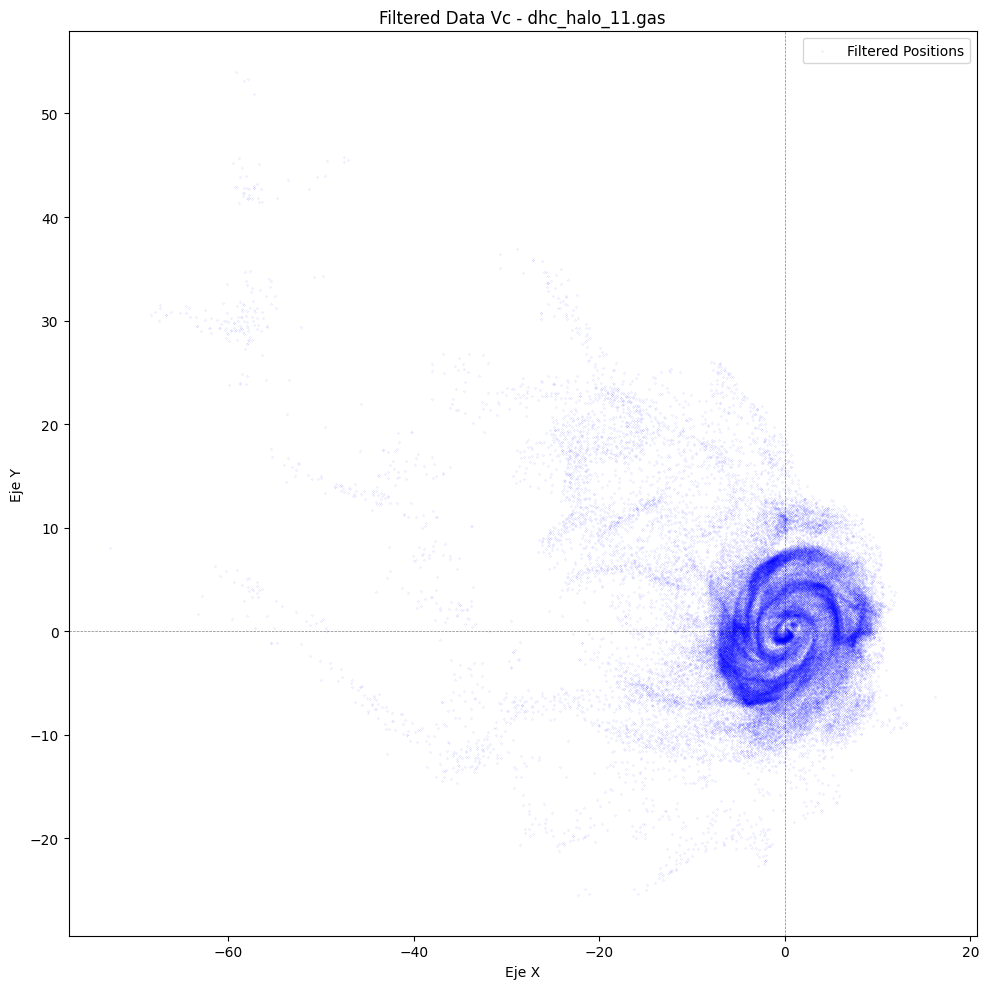

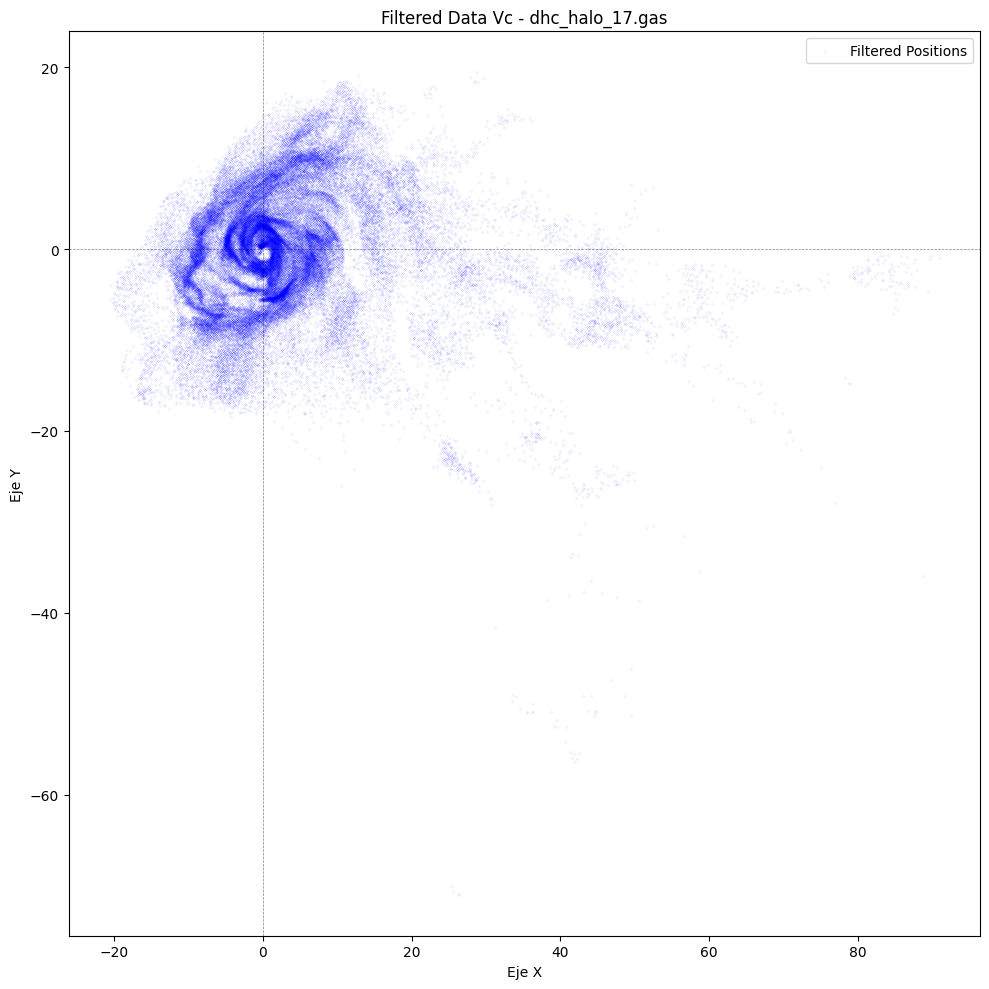

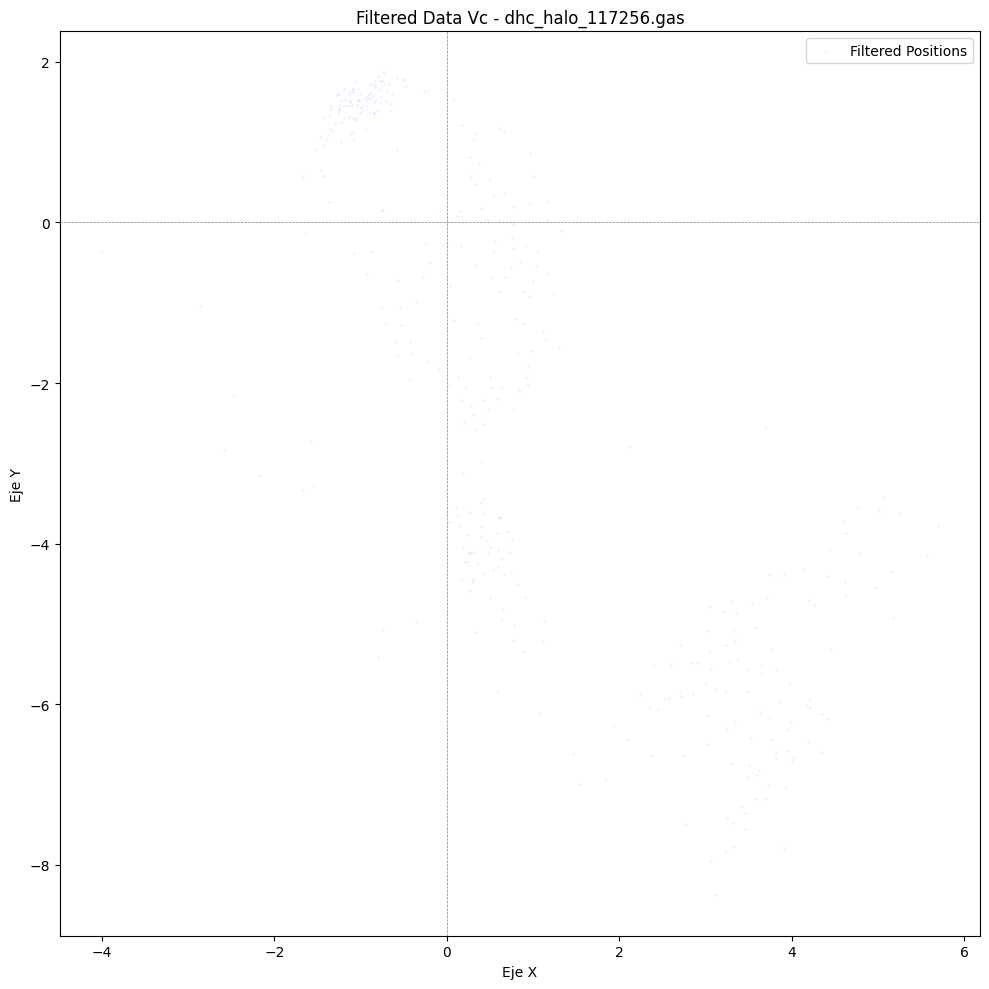

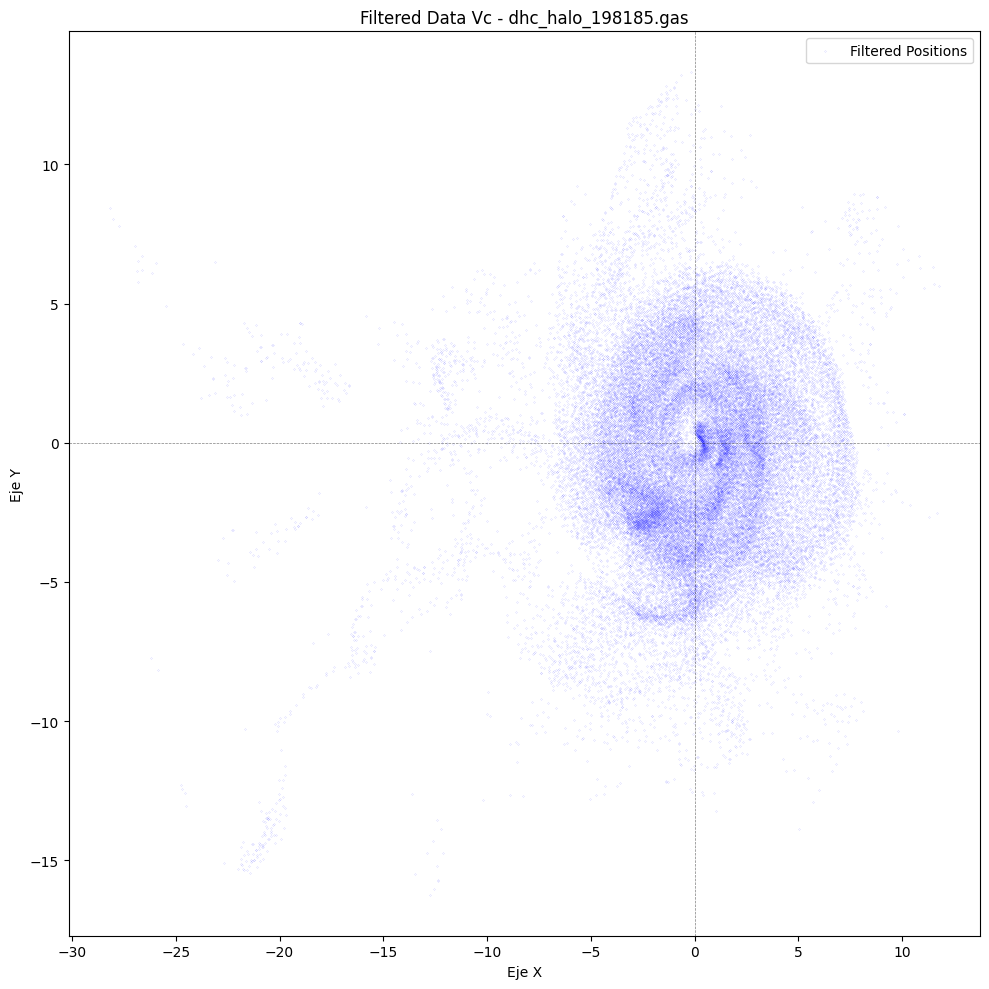

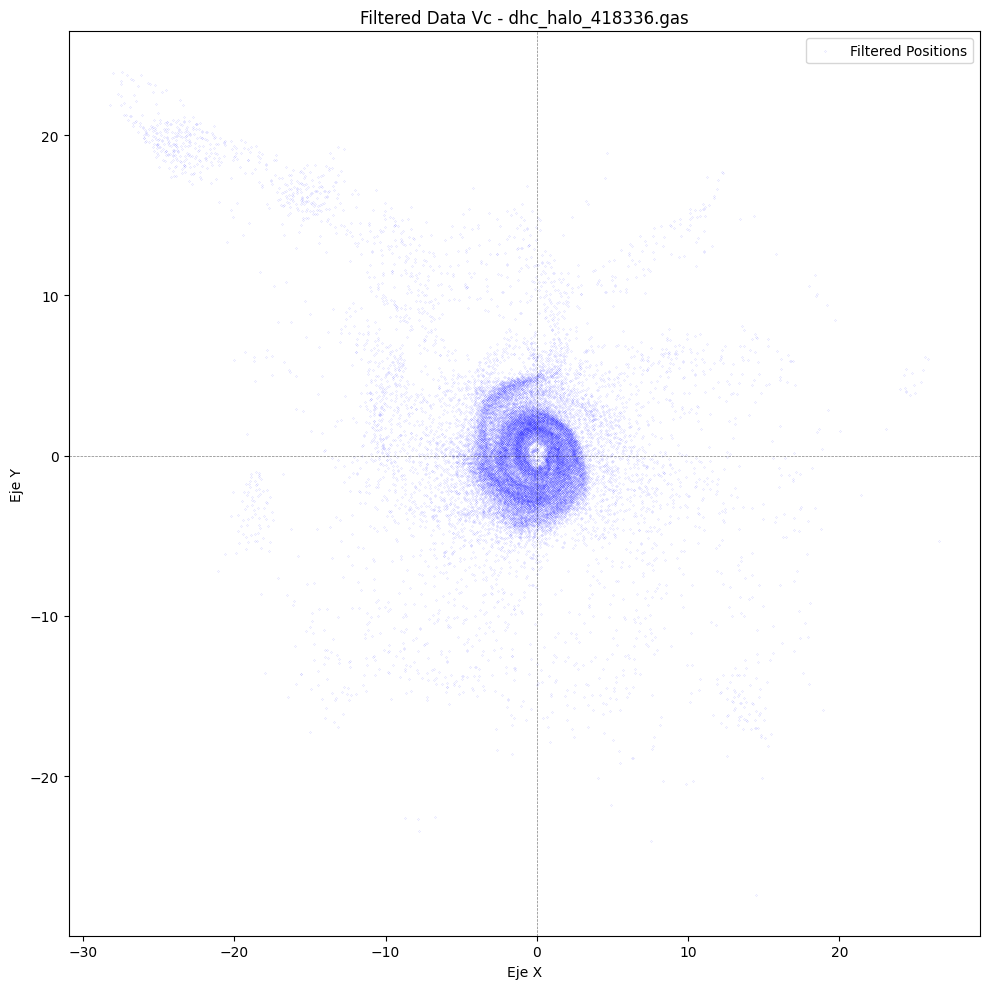

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

def visualize_filtered_data(filtered_df, title):
    # Crear una figura con un subgráfico
    fig, ax = plt.subplots(figsize=(10, 10))

    # Gráfico de las posiciones filtradas
    ax.scatter(filtered_df.iloc[:, 0], filtered_df.iloc[:, 1], color='blue', marker='o', s=0.003, label='Filtered Positions')
    ax.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)

    ax.set_title(title)
    #ax.set_xlim(-18, 18)
    #ax.set_ylim(-18, 18)
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.legend()

    # Ajustar el diseño para evitar superposiciones
    plt.tight_layout()
    plt.show()

# Nombre de los archivos
halo_files = ['dhc_halo_11.gas', 'dhc_halo_17.gas', 'dhc_halo_117256.gas', 'dhc_halo_198185.gas', 'dhc_halo_418336.gas']

filtered_dataframes = {}

for idx, file_path in enumerate(halo_files):
    simulation = TNG50DataProcessor(file_path)
    center_of_mass = simulation.calculate_center_of_mass_new(2.63)
    total_angular_momentum = simulation.calculate_total_angular_momentum()
    angular_direction = np.sign(total_angular_momentum)
    largest_component = np.argmax(np.abs(total_angular_momentum))
    direction = angular_direction[largest_component]

    rotation_handler = RotationHandler(direction)
    angle_rotation_matrix = rotation_handler.choose_rotation_matrix(largest_component, direction)

    original_vectors = simulation.accumulated_data[:, :3]
    velocity_vectors = simulation.accumulated_data[:, 3:6]
    rotated_vectors_position = rotation_handler.apply_rotation(angle_rotation_matrix, original_vectors)
    rotated_vectors_velocity = rotation_handler.apply_rotation(angle_rotation_matrix, velocity_vectors)

    rotated_data = np.concatenate([rotated_vectors_position, rotated_vectors_velocity, simulation.accumulated_data[:, 6:]], axis=1)
    potential = simulation.accumulated_data[:, 9]

    # Para los datos rotados se calculan magnitudes y cantidades
    calculator = VelocityEscapeCalculator(rotated_data, potential)
    calculator.calculate_magnitudes()
    calculator.calculate_escape_velocity()

    processed_data = calculator.get_processed_data()

    # Grid
    v_circ_min, v_circ_max = processed_data['velocity_magnitude'].min(), processed_data['velocity_magnitude'].max()
    v_esc_min, v_esc_max = processed_data['escape_velocity'].min(), processed_data['escape_velocity'].max()

    v_circ_bins = np.arange(v_circ_min, v_circ_max, 8)
    v_esc_bins = np.arange(v_esc_min, v_esc_max, 8)

    grid_data = np.zeros((len(v_circ_bins) - 1, len(v_esc_bins) - 1))
    point_density = np.zeros((len(v_circ_bins) - 1, len(v_esc_bins) - 1))

    for i, j in [(i, j) for i in range(len(v_circ_bins) - 1) for j in range(len(v_esc_bins) - 1)]:
        mask = ((processed_data['velocity_magnitude'] >= v_circ_bins[i]) &
                (processed_data['velocity_magnitude'] < v_circ_bins[i + 1]) &
                (processed_data['escape_velocity'] >= v_esc_bins[j]) &
                (processed_data['escape_velocity'] < v_esc_bins[j + 1]))

        points_in_cell = processed_data[mask]['velocity_magnitude']
        point_density[i, j] = len(points_in_cell)
        if len(points_in_cell) > 0:
            grid_data[i, j] = np.mean(points_in_cell)

    weighted_avg_velocity_per_column = [
        np.average(grid_data[:, j], weights=point_density[:, j]) if np.sum(point_density[:, j]) > 0 else np.nan
        for j in range(grid_data.shape[1])
    ]

    weighted_avg_velocity_per_column = np.array(weighted_avg_velocity_per_column)
    v_esc_midpoints = (v_esc_bins[:-1] + v_esc_bins[1:]) / 2
    max_avg_velocity = np.nanmax(weighted_avg_velocity_per_column)

    # criterio del 70% de la velocidad máxima promedio
    threshold = 0.8 * max_avg_velocity
    filtered_data = processed_data[processed_data['velocity_magnitude'] > threshold]

    filtered_df = pd.DataFrame(filtered_data, columns=['x', 'y', 'z', 'vx', 'vy', 'vz', 'mass', 'potential', 'escape_velocity', 'velocity_magnitude'])
    filtered_dataframes[file_path] = filtered_df

    # Graficar las posiciones de los datos filtrados
    visualize_filtered_data(filtered_df[['x', 'y']], f'Filtered Data Vc - {file_path}')